# Hyperparameter Tuning - CNN+LSTM

## Imports

In [1]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 KB 9.8 MB/s eta 0:00:00


In [111]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 KB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171048 sha256=4696868f365064c421f7a731d719e10d2b868cfcd1b663abf6c7d3de094ef1fc
  Stored in directory: /root/.cache/pip/wheels/fa/7a/e9/22dd0515e1bad255e51663ee513a2fa839c95934c5fc301090
Successfully built emoji


In [75]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from collections import Counter
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import hyperparameters
import json

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Mounting the drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the Data

In [4]:
#Loading the Dataset
dataset = pd.read_csv('/content/drive/MyDrive/CZ4034/balanced_data.csv')
dataset.drop('Unnamed: 0', axis=1, inplace=True)

# # of rows = 5000, # of cols = 2
print(dataset.shape)

(1960, 2)


In [5]:
#Exploring the Dataset
print(dataset['flair_labels'].value_counts())

1    980
0    980
Name: flair_labels, dtype: int64


In [6]:
#Count all the unique words - input to fxn: column [series]
prev_list = []

for review in dataset.Review:
    string_list = review.split(' ')
    string_list += prev_list
    prev_list = string_list

counter = Counter(string_list)

#Getting the number of unique words
num_unique_words = len(counter)

#Getting the top 10 most commonly used words
most_common = counter.most_common(10)

most_common

[('skin', 1908),
 ('product', 728),
 ('like', 588),
 ('using', 489),
 ('use', 485),
 ('really', 471),
 ('face', 463),
 ('love', 449),
 ('ive', 316),
 ('dry', 313)]

In [7]:
#Splitting into trianing and validation splits
x_train, x_val, y_train, y_val = train_test_split(dataset['Review'], dataset['flair_labels'], test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

print(f"Train: {len(x_train)}")
print(f"Val: {len(x_val)}")
print(f"Test: {len(x_test)}")
# Train - 1568 , Test - 392

Train: 1568
Val: 196
Test: 196


In [8]:
#Convert from Series into Numpy Array
train_sentences = x_train.to_numpy()
train_labels = y_train.to_numpy()

val_sentences = x_val.to_numpy()
val_labels = y_val.to_numpy()

test_sentences = x_test.to_numpy()
test_labels = y_test.to_numpy()

In [9]:
#Tokenization - vectorise a text corpus by converting text into a sequence of integers
#this also generates a word index
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

#writing the word index into a text file

with open("/content/drive/MyDrive/CZ4034/balanced_data_word_idx.txt", 'w') as f:
    f.write(json.dumps(word_index))

In [10]:
#Converting the text into sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

#Getting the longest review
MAX_LEN = len(max(train_sequences))

#Padding the Sequences
train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [11]:
print('Train:',train_padded.shape)
print('Val:',val_padded.shape)
print('Test:',test_padded.shape)
"""
NOTE: 
  • Train Padded Shape: (1568, 22)
  • Valid Padded Shape: (196, 22)
  • Test Padded Shape: (392, 22)
"""

Train: (1568, 22)
Val: (196, 22)
Test: (196, 22)


'\nNOTE: \n  • Train Padded Shape: (1568, 22)\n  • Valid Padded Shape: (196, 22)\n  • Test Padded Shape: (392, 22)\n'

In [12]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
val_labels = le.fit_transform(val_labels)
test_labels = le.fit_transform(test_labels)

In [13]:
print(f"Training")
print(f"0: {list(train_labels).count(0)}")
print(f"1: {list(train_labels).count(1)}\n")

print("Val")
print(f"0: {list(val_labels).count(0)}")
print(f"1: {list(val_labels).count(1)}\n")

print("Test")
print(f"0: {list(test_labels).count(0)}")
print(f"1: {list(test_labels).count(1)}\n")

Training
0: 792
1: 776

Val
0: 96
1: 100

Test
0: 92
1: 104



## Loading the Model

In [14]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/CZ4034/CNN_LSTM/model.hdf5')
loaded_model

In [85]:
def build_model(hp):
  model = Sequential([
      Embedding(num_unique_words, 
                output_dim=hp.Int('num_embedding_neurons', min_value=50, max_value=200, step=50), 
                input_length=MAX_LEN, 
                trainable=True),
      Conv1D(filters=hp.Int('conv1_filter', min_value=32, max_value=128, step=16), 
           kernel_size=hp.Choice('conv1_kernel_size', values=[3,5]),
           padding='same', 
           activation='relu'),
      MaxPooling1D(pool_size=2),
      LSTM(hp.Int('num_LSTM_nodes',min_value=50, max_value=300, step=50)),
      Dense(1, activation='sigmoid')])

  model.compile(loss='binary_crossentropy', optimizer=Adam(hp.Choice('lr', values=[1e-2, 1e-3])), metrics=['accuracy'])

  return model

In [86]:
random_search = RandomSearch(build_model, objective='val_accuracy', max_trials=10, directory='/content/drive/MyDrive/CZ4034/RandomSearch_CNNLSTM', project_name='CNN_LSTM')

In [87]:
#Getting a full summary
random_search.search_space_summary()

Search space summary
Default search space size: 5
num_embedding_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
conv1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv1_kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
num_LSTM_nodes (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 300, 'step': 50, 'sampling': 'linear'}
lr (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


In [88]:
#runs the whole random search to get best hyperparamters
random_search.search(train_padded, train_labels, epochs=10, validation_data=(val_padded, val_labels))

Trial 10 Complete [00h 00m 43s]
val_accuracy: 0.7704081535339355

Best val_accuracy So Far: 0.7908163070678711
Total elapsed time: 00h 05m 41s


In [91]:
best_hyp = random_search.get_best_hyperparameters()[0]
optimized_model = random_search.hypermodel.build(best_hyp)
optimized_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 22, 200)           943400    
                                                                 
 conv1d_2 (Conv1D)           (None, 22, 80)            48080     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 11, 80)           0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 250)               331000    
                                                                 
 dense_2 (Dense)             (None, 1)                 251       
                                                                 
Total params: 1,322,731
Trainable params: 1,322,731
Non-trainable params: 0
____________________________________________

In [103]:
trial02 = '{"trial_id": "02", "hyperparameters": {"space": [{"class_name": "Int", "config": {"name": "num_embedding_neurons", "default": null, "conditions": [], "min_value": 50, "max_value": 200, "step": 50, "sampling": "linear"}}, {"class_name": "Int", "config": {"name": "conv1_filter", "default": null, "conditions": [], "min_value": 32, "max_value": 128, "step": 16, "sampling": "linear"}}, {"class_name": "Choice", "config": {"name": "conv1_kernel_size", "default": 3, "conditions": [], "values": [3, 5], "ordered": true}}, {"class_name": "Int", "config": {"name": "num_LSTM_nodes", "default": null, "conditions": [], "min_value": 50, "max_value": 300, "step": 50, "sampling": "linear"}}, {"class_name": "Choice", "config": {"name": "lr", "default": 0.01, "conditions": [], "values": [0.01, 0.001], "ordered": true}}], "values": {"num_embedding_neurons": 200, "conv1_filter": 80, "conv1_kernel_size": 3, "num_LSTM_nodes": 250, "lr": 0.001}}, "metrics": {"metrics": {"loss": {"direction": "min", "observations": [{"value": [0.007286782842129469], "step": 5}]}, "accuracy": {"direction": "max", "observations": [{"value": [0.9974489808082581], "step": 5}]}, "val_loss": {"direction": "min", "observations": [{"value": [1.1164275407791138], "step": 5}]}, "val_accuracy": {"direction": "max", "observations": [{"value": [0.7908163070678711], "step": 5}]}}}, "score": 0.7908163070678711, "best_step": 5, "status": "COMPLETED", "message": null}'

Optimized Model - trial02 in the current CNN_LSTM folder:

1. num_embedding_neurons = 200
2. conv1_filter = 80
3. conv1_kernel_size = 3
4. num_LSTM_nodes = 250
5. lr = 0.001

## Retraining Optimized Model on the Training Dataset

In [93]:
history_opt = optimized_model.fit(train_padded, train_labels, epochs=10, validation_data=(val_padded, val_labels))

Epoch 1/10
49/49 [==============================] - 12s 157ms/step - loss: 0.6543 - accuracy: 0.5963 - val_loss: 0.5692 - val_accuracy: 0.7143
Epoch 2/10
49/49 [==============================] - 4s 71ms/step - loss: 0.3497 - accuracy: 0.8552 - val_loss: 0.5097 - val_accuracy: 0.7602
Epoch 3/10
49/49 [==============================] - 3s 50ms/step - loss: 0.1275 - accuracy: 0.9598 - val_loss: 0.6564 - val_accuracy: 0.8010
Epoch 4/10
49/49 [==============================] - 1s 30ms/step - loss: 0.0420 - accuracy: 0.9872 - val_loss: 0.7065 - val_accuracy: 0.7602
Epoch 5/10
49/49 [==============================] - 1s 15ms/step - loss: 0.0234 - accuracy: 0.9917 - val_loss: 1.1398 - val_accuracy: 0.7602
Epoch 6/10
49/49 [==============================] - 1s 18ms/step - loss: 0.0080 - accuracy: 0.9981 - val_loss: 1.1099 - val_accuracy: 0.7653
Epoch 7/10
49/49 [==============================] - 1s 21ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.5096 - val_accuracy: 0.7602
Epoch 8/10


In [94]:
with open('/content/drive/MyDrive/CZ4034/RandomSearch_CNNLSTM/optimized_hist_cnn_lstm.txt', 'w') as convert_file:
     convert_file.write(json.dumps(history_opt.history))

In [95]:
random_search.get_best_hyperparameters

<bound method BaseTuner.get_best_hyperparameters of <keras_tuner.tuners.randomsearch.RandomSearch object at 0x7f5d930d4e20>>

## Plotting Loss and Accuracy Curves

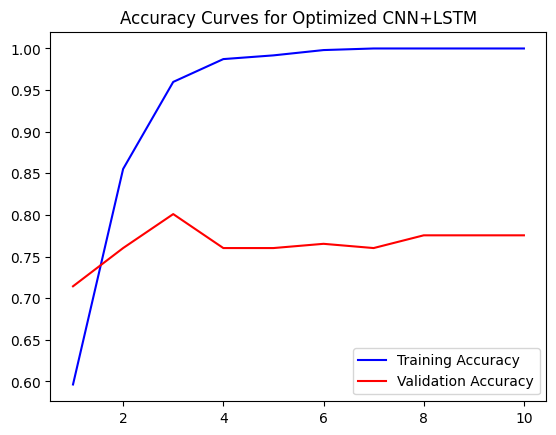

<Figure size 640x480 with 0 Axes>

In [96]:
#PLOTTING THE CURVES
epochs = range(1,11)

#Plotting the Accuracy Curves
train_accuracy = history_opt.history['accuracy']
val_accuracy = history_opt.history['val_accuracy']

plt.plot(epochs,train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs,val_accuracy, 'r', label='Validation Accuracy')
plt.title('Accuracy Curves for Optimized CNN+LSTM')
plt.legend()
plt.figure()
plt.savefig('/content/drive/MyDrive/CZ4034/RandomSearch_CNNLSTM/cnnlstm_opt_try1_Accuracy.jpg')

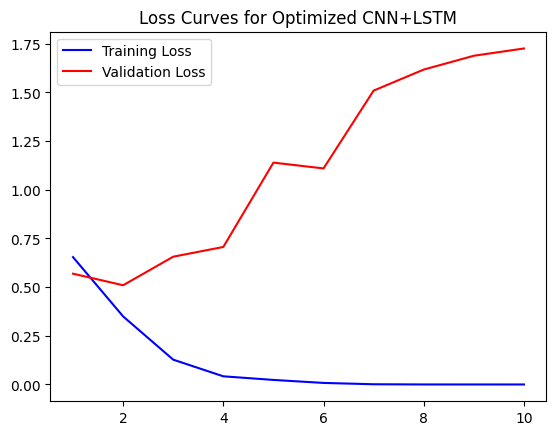

<Figure size 640x480 with 0 Axes>

In [97]:
#Plotting the Loss Curves
train_loss = history_opt.history['loss']
val_loss = history_opt.history['val_loss']

plt.plot(epochs,train_loss, 'b', label='Training Loss')
plt.plot(epochs,val_loss, 'r', label='Validation Loss')
plt.title('Loss Curves for Optimized CNN+LSTM')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/CZ4034/RandomSearch_CNNLSTM/cnnlstm_opt_try1_Loss.jpg')

## Evaluating the Optimized model

In [98]:
prev_model_scores = loaded_model.evaluate(test_padded, test_labels, verbose=1,batch_size = 64)
print("Accuracy: %.2f%%" % (prev_model_scores[1]*100))

4/4 [==============================] - 0s 5ms/step - loss: 0.9772 - accuracy: 0.7551
Accuracy: 75.51%


In [99]:
optimized_model_scores = optimized_model.evaluate(test_padded, test_labels, verbose=1, batch_size=64)
print("Accuracy: %.2f%%" % (optimized_model_scores[1]*100))

4/4 [==============================] - 0s 8ms/step - loss: 1.9022 - accuracy: 0.7755
Accuracy: 77.55%


In [100]:
optimized_model.save('/content/drive/MyDrive/CZ4034/RandomSearch_CNNLSTM/optimized_model.hdf5')

### Getting Components of the Confusion Matrix

#### Previous Model

In [104]:
prev_predictions = loaded_model.predict(test_padded)
prev_predictions = [1 if p > 0.5 else 0 for p in prev_predictions]

7/7 [==============================] - 0s 3ms/step


In [109]:
from sklearn.metrics import confusion_matrix

prev_conf_matrix = confusion_matrix(test_labels, prev_predictions)
p_tn, p_fp, p_fn, p_tp = prev_conf_matrix.ravel()

print("Previous Model:")

print(f"True Positives: {p_tp}")
print(f"True Negatives: {p_tn}")
print(f"False Positives: {p_fp}")
print(f"False Negatives: {p_fn}")

Previous Model:
True Positives: 83
True Negatives: 65
False Positives: 27
False Negatives: 21


#### Optimized Model

In [105]:
optimized_predictions = optimized_model.predict(test_padded)
optimized_predictions = [1 if p > 0.5 else 0 for p in optimized_predictions]

7/7 [==============================] - 0s 3ms/step


In [110]:
from sklearn.metrics import confusion_matrix

opt_conf_matrix = confusion_matrix(test_labels, optimized_predictions)
o_tn, o_fp, o_fn, o_tp = opt_conf_matrix.ravel()

print("Optimized Model:")

print(f"True Positives: {o_tp}")
print(f"True Negatives: {o_tn}")
print(f"False Positives: {o_fp}")
print(f"False Negatives: {o_fn}")

Optimized Model:
True Positives: 82
True Negatives: 70
False Positives: 22
False Negatives: 22


## Testing on Individual Texts

In [115]:
#Function to process the test sample in the same way as the data processing of training
import numpy as np
from cleantext import clean

#takes in a string(text) and returns a padded sequence 
def process_eval_sample(text):
  text = clean(text, no_emoji=True, no_punct=True, lower=True)
  text = text.split(" ")
  sentence = np.array(text)
  sequence = tokenizer.texts_to_sequences(sentence)
  padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')

  return padded_sequence

#takes in a padded sequence and returns an integer (0 or 1) for the label
def pred_prev_model(padded_seq):
  predictions = loaded_model.predict(padded_seq)[0]
  print(f"Predicted Value: {predictions}")
  pred_values = [1 if p>=0.5 else 0 for p in predictions]
  pred_label = max(pred_values)

  return pred_label

def pred_optimized_model(padded_seq):
  predictions = optimized_model.predict(padded_seq)[0]
  print(f"Predicted Value: {predictions}")
  pred_values = [1 if p>=0.5 else 0 for p in predictions]
  pred_label = max(pred_values)

  return pred_label

### Previous Model

In [119]:
eval1_text = "cured my acne scars. Worked miraculously"
gt1_label = '1'

eval1 = process_eval_sample(eval1_text)
eval1_label = pred_prev_model(eval1)

print(f"Eval Sample 1: {eval1_text}")
print(f"Ground Truth Label: {gt1_label}")
print(f"Predicted Label: {eval1_label}")

1/1 [==============================] - 0s 263ms/step
Predicted Value: [0.33626953]
Eval Sample 1: cured my acne scars. Worked miraculously
Ground Truth Label: 1
Predicted Label: 0


In [117]:
eval2_text = "I purchased this cream in hopes it would be good. It definitely hydrates my skin, but it does leave my face really shiny as if it’s oily. Not happy with this look and so I’ve ended up just using it only at night. Or, if I know I’m not venturing out anywhere, I’ll apply it on. May not purchase this again."
gt2_label = '0'

eval2 = process_eval_sample(eval2_text)
eval2_label = pred_prev_model(eval2)

print(f"Predictions: {loaded_model.predict(eval2)[0]}")
print(f"Eval Sample 2: {eval2_text}")
print(f"Ground Truth Label: {gt2_label}")
print(f"Predicted Label: {eval2_label}")

2/2 [==============================] - 0s 39ms/step
Predicted Value: [0.3362695]
2/2 [==============================] - 0s 9ms/step
Predictions: [0.3362695]
Eval Sample 2: I purchased this cream in hopes it would be good. It definitely hydrates my skin, but it does leave my face really shiny as if it’s oily. Not happy with this look and so I’ve ended up just using it only at night. Or, if I know I’m not venturing out anywhere, I’ll apply it on. May not purchase this again.
Ground Truth Label: 0
Predicted Label: 0


In [118]:
eval3_text = "best product ever!"
gt3_label = '1'

eval3 = process_eval_sample(eval3_text)
eval3_label = pred_prev_model(eval3)

print(f"Eval Sample 3: {eval3_text}")
print(f"Ground Truth Label: {gt3_label}")
print(f"Predicted Label: {eval3_label}")

1/1 [==============================] - 0s 63ms/step
Predicted Value: [0.82507575]
Eval Sample 3: best product ever!
Ground Truth Label: 1
Predicted Label: 1


### Optimized Model

In [120]:
eval1_text = "cured my acne scars. Worked miraculously"
gt1_label = '1'

eval1 = process_eval_sample(eval1_text)
eval1_label = pred_optimized_model(eval1)

print(f"Eval Sample 1: {eval1_text}")
print(f"Ground Truth Label: {gt1_label}")
print(f"Predicted Label: {eval1_label}")

1/1 [==============================] - 0s 38ms/step
Predicted Value: [0.92191094]
Eval Sample 1: cured my acne scars. Worked miraculously
Ground Truth Label: 1
Predicted Label: 1


In [130]:
eval2_text = "I purchased this cream in hopes it would be good. It definitely hydrates my skin, but it does leave my face really shiny as if it’s oily. Not happy with this look and so I’ve ended up just using it only at night. Or, if I know I’m not venturing out anywhere, I’ll apply it on. May not purchase this again."
gt2_label = '0'

eval2 = process_eval_sample(eval2_text)
eval2_label = pred_optimized_model(eval2)

print(f"Predictions: {loaded_model.predict(eval2)[0]}")
print(f"Eval Sample 2: {eval2_text}")
print(f"Ground Truth Label: {gt2_label}")
print(f"Predicted Label: {eval2_label}")

2/2 [==============================] - 0s 13ms/step
Predicted Value: [0.92191094]
2/2 [==============================] - 0s 5ms/step
Predictions: [0.3362695]
Eval Sample 2: I purchased this cream in hopes it would be good. It definitely hydrates my skin, but it does leave my face really shiny as if it’s oily. Not happy with this look and so I’ve ended up just using it only at night. Or, if I know I’m not venturing out anywhere, I’ll apply it on. May not purchase this again.
Ground Truth Label: 0
Predicted Label: 1


In [131]:
eval3_text = "best product ever!"
gt3_label = '1'

eval3 = process_eval_sample(eval3_text)
eval3_label = pred_optimized_model(eval3)

print(f"Eval Sample 3: {eval3_text}")
print(f"Ground Truth Label: {gt3_label}")
print(f"Predicted Label: {eval3_label}")

1/1 [==============================] - 0s 66ms/step
Predicted Value: [0.99958736]
Eval Sample 3: best product ever!
Ground Truth Label: 1
Predicted Label: 1
